Sentiment Model Training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.datasets import imdb

In [ ]:
((XT,YT),(Xt,Yt)) = imdb.load_data()

In [ ]:
word_idx = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
idx_words = dict([value,key] for (key,value) in word_idx.items())
#print(word_idx.items())

In [ ]:
actual_review = ' '.join(idx_words.get(idx-3,'?') for idx in Xt[3])
#print(Xt[3])
#print(actual_review)
#print(XT[0])
#print(Yt[3])

In [ ]:
#print(XT)
print(type(XT))

<class 'numpy.ndarray'>


In [ ]:
#Imports
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Vectorization
from nltk.tokenize import RegexpTokenizer

#stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#SnowballStemmer
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def stopwordRemoval(sen):
  sw = (stopwords.words('english'))
  useful = ['few','only','don',"don't",'not','but','if','until','or','while','by','about','against','below','above','up','down','off','again','when','both','no','such','nor',"dont't",'should',"should've"]
  sw = sw[:142]
  sw = [word for word in sw if word not in useful]
  sen = [word.lower() for word in sen if word.lower() not in sw]
  return sen

def stem(sen):
  ss = SnowballStemmer(language = ('english'))
  sen = [ss.stem(word) for word in sen] 
  return sen

#preprocessing on trainingData

def vectorize(XT):                         #stopwordRemoval + Stemming + Vectorization
  corpus = []
  #Getting actual reviews 
  for i in XT:
    sen = ' '.join(idx_words.get(idx-3,'?') for idx in i)
    corpus.append(sen)
  

  tokenizer = RegexpTokenizer('[a-zA-Z\']+')   
  i = 0
  #Tokenization + StopwordRemoval + Stemming
  for sen in corpus:
    sen = tokenizer.tokenize(sen) 
    sen = stopwordRemoval(sen)
    #sen = stem(sen)
    sen = ' '.join(word for word in sen)
    corpus[i] = sen
    i = i+1
  
  #Vectorization
  cv = CountVectorizer(max_features = 10000)
  vect = cv.fit_transform(corpus)
  vocab = cv.vocabulary_
  invVocab = dict(zip(vocab.values(), vocab.keys()))

  #Making new XTrain
  XVec = []
  for i in corpus:
    i = i.split()
    item = [vocab.get(key) for key in i if vocab.get(key) != None]
    XVec.append(item)

  XVec = np.array(XVec)
  return cv, XVec, vocab, invVocab


In [ ]:
cv,XT_,vocab,invVocab = vectorize(XT)
#save vocab, invVocab

In [ ]:
#Preprocessing on testingData

def preProcess(Xt,vocab):
  corpus = []
  #Getting actual reviews 
  for i in Xt:
    sen = ' '.join(idx_words.get(idx-3,'?') for idx in i)
    corpus.append(sen)
  

  tokenizer = RegexpTokenizer('[a-zA-Z\']+')   
  i = 0
  #StopwordRemoval + Stemming
  for sen in corpus:
    sen = tokenizer.tokenize(sen) 
    sen = stopwordRemoval(sen)
    #sen = stem(sen)
    sen = ' '.join(word for word in sen)
    corpus[i] = sen
    i = i+1
  
  XVec = []
  for i in corpus:
    i = i.split()
    item = [vocab.get(key) for key in i if vocab.get(key) != None]
    XVec.append(item)


  XVec = np.array(XVec)
  return XVec


In [ ]:
Xt_ = preProcess(Xt,vocab)

In [ ]:
#print(XT_)
#print(Xt_)
#print(vocab)
#print(invVocab)

In [ ]:
#saving voabulary
filehandler = open('vocabFile.txt', 'wt')
data = str(vocab)
filehandler.write(data)

165946

In [ ]:
import matplotlib.pyplot as plt

119.7056


(array([ 2740., 11407.,  4808.,  2510.,  1379.,   845.,   498.,   308.,
          237.,   183.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <a list of 10 Patch objects>)

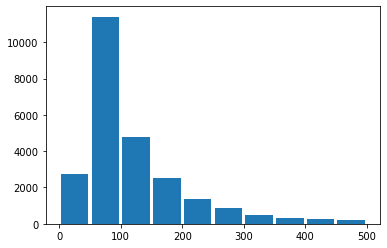

In [ ]:
length = []
l = 0
i = 0
for vect in XT_:
  l += len(vect)
  length.append(len(vect))
  i += 1
print(l/i)
plt.hist(length,range = (0,500),rwidth = 0.9)

In [ ]:
from tensorflow.keras.preprocessing import sequence
X_train = sequence.pad_sequences(XT_,maxlen = 500)
X_test = sequence.pad_sequences(Xt_, maxlen = 500)

In [ ]:
from keras.utils import to_categorical
YT_ = to_categorical(YT)
Yt_ = to_categorical(Yt)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D

In [ ]:
model = Sequential()
model.add(Embedding(10000,64))
model.add(LSTM(32))
model.add(Dropout(0.4))
model.add(Dense(2,activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 652,482
Trainable params: 652,482
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compiling model
model.compile(optimizer = "RMSProp", loss = 'categorical_crossentropy', metrics = ['acc'])
#For saving only the best weights for val_acc
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("sentimentModel.h5",monitor = 'val_loss',verbose = 0,save_best_only = True,save_weights_only = False, mode = 'auto',period = 1)
#Early stopping is also an option
from keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor = 'val_acc',patience = 3)

In [ ]:
hist = model.fit(X_train,YT_, validation_split = 0.1, epochs = 10, batch_size = 256, callbacks = [checkpoint, earlyStop])

Epoch 1/10
88/88 [==============================] - 10s 116ms/step - loss: 0.4748 - acc: 0.7950 - val_loss: 0.4357 - val_acc: 0.8332
Epoch 2/10
88/88 [==============================] - 9s 108ms/step - loss: 0.2714 - acc: 0.9010 - val_loss: 0.3154 - val_acc: 0.8852
Epoch 3/10
88/88 [==============================] - 9s 105ms/step - loss: 0.2101 - acc: 0.9266 - val_loss: 0.2904 - val_acc: 0.8836
Epoch 4/10
88/88 [==============================] - 9s 104ms/step - loss: 0.1751 - acc: 0.9383 - val_loss: 0.3111 - val_acc: 0.8844
Epoch 5/10
88/88 [==============================] - 9s 105ms/step - loss: 0.1514 - acc: 0.9479 - val_loss: 0.3266 - val_acc: 0.8772


In [ ]:
acc = hist.history['acc']
loss = hist.history['loss']
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']

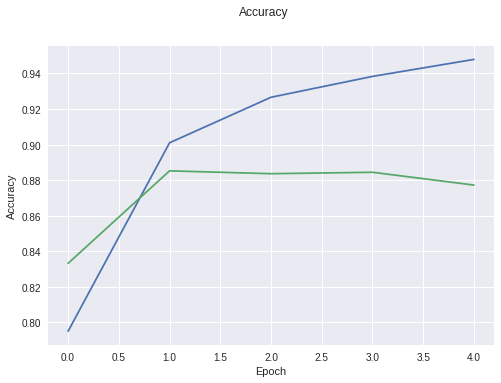

In [ ]:
plt.style.use("seaborn")
fig = plt.figure()
fig.suptitle('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc,label = 'training_acc')
plt.plot(val_acc, label = 'val_acc')
plt.show()

In [ ]:
model.save('sentimentModel.h5')

In [ ]:
import tensorflow as tf

In [ ]:
loss, acc = model.evaluate(X_test,Yt_)

782/782 [==============================] - 24s 30ms/step - loss: 0.3554 - acc: 0.8656


In [ ]:
pred = np.argmax(model.predict(X_test),axis = 1)

Calculating Expected time of computaion per comment




In [ ]:
def computationTime(n):
    X_Vec = X_test[0:n]
    out = np.argmax(model.predict(X_Vec),axis = 1)
    print(out)
    return 

In [ ]:
#time observed with stopwatch
#computationTime(1) -> 1.48sec
#computationTime(50) -> 1.49sec
#computationTime(100) -> 1.50sec
#computationTime(500) -> 1.52sec
#computationTime(1000) -> 1.72sec
#computationTime(2000) -> 1.89sec
#computationTime(5000) -> 2.42ssc
#computationTime(10000) -> 4.33sec
#computationTime(20000) -> 6.94sec

In [35]:
import numpy as np
import matplotlib.pyplot as plt

Single Server Queuing System (for analysis of model Perfomance)

In [54]:
class StateVariables:
    def __init__(self):
        self.serverStatus = 0
        self.numberInQueue = 0
        self.timeOfArrival = []
        self.lastEvent = 0

class StatisticalCounters:
    def __init__(self):
        self.numberDelayed = 0
        self.totalDelay = 0
        self.areaQ = 0
        self.areaB = 0
        self.Q = [[0, 0]]
        self.B = [[0, 0]]

class clock:
    def __init__(self):
        self.time = 0
        self.eventList = [1,100]        #arrival(50 comments), departure


def libraryRoutine(c):
    time = c.time
    if (time - time.astype(int)) == 0:
        return time+1
    else:
        return time.astype(int) + 1

def initialisationRoutine():
    sv = StateVariables()
    sc = StatisticalCounters()
    c = clock()
    return sv,sc,c


def timingRoutine(c):
    el = c.eventList
    c.time = np.min(el)
    return c.time, np.argmin(el)

def eventRoutine(sv,sc,c,eventType):
    sc.Q.append([sv.numberInQueue*50, c.time])
    sc.B.append([sv.serverStatus, c.time])
    if (sv.serverStatus == 1):
        sc.areaB += (c.time - sv.lastEvent)
    sc.areaQ += ((c.time - sv.lastEvent)*(sv.numberInQueue)*50)
    
    if (eventType == 1):
        sv.serverStatus = 0
        c.eventList[1] = 100

    if (eventType == 0):
        sv.numberInQueue += 1
        sv.timeOfArrival.append(c.time)
        c.eventList[0] = libraryRoutine(c)
    
    if (sv.serverStatus == 0 and sv.numberInQueue>=2):
        
        for t in sv.timeOfArrival:
            sc.totalDelay += (c.time - t)*50
        sc.numberDelayed += (sv.numberInQueue*50)
        sv.serverStatus = 1
        sc.B.append([1,c.time])
        sv.numberInQueue = 0
        sv.timeOfArrival = []
        c.eventList[1] = c.time + 1.5

    sc.Q.append([sv.numberInQueue*50, c.time])
    sc.B.append([sv.serverStatus, c.time])
    sv.lastEvent = c.time
    return sv,sc,c


def ssqs():
    sv,sc,c = initialisationRoutine()
    while (sc.numberDelayed < 1000):
        nextEvent, eventType = timingRoutine(c)
        sv,sc,c = eventRoutine(sv,sc,c,eventType)
    
    Qn = sc.areaQ/c.time
    Bn = sc.areaB/c.time
    avgDelay = sc.totalDelay/sc.numberDelayed
    Q = sc.Q
    B = sc.B
    return sc.numberDelayed, avgDelay, Qn, Bn, Q, B


In [55]:
numberDelayed, avgDelay, Qn, Bn, Q, B = ssqs()

In [56]:
print(numberDelayed, avgDelay, Qn, Bn)

1000 0.5 25.0 0.675


In [57]:
#Quiet good a perfomance for a server with traffic of 50 comments/second

Plotting Q(t) and B(t)

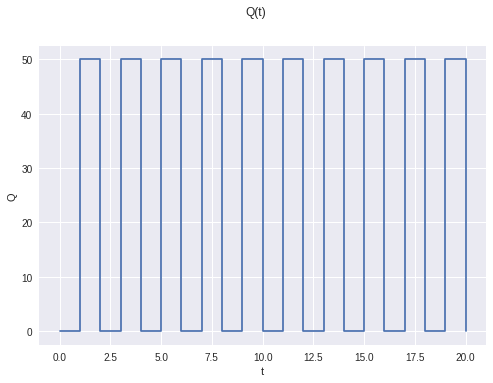

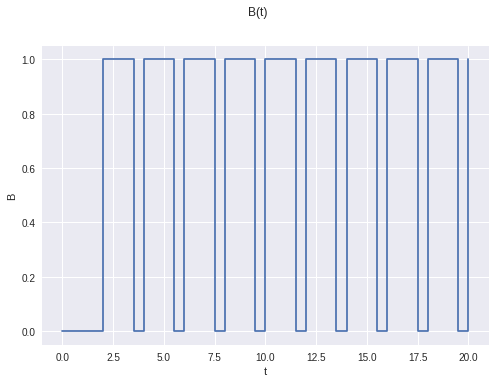

In [60]:
Qq = []
Qt = []
Bb = []
Bt = []

i = 0
for q in Q:
    Qt.append(q[1])
    Qq.append(q[0])
    i+=1

i = 0
for b in B:
    Bt.append(b[1])
    Bb.append(b[0])
    i+=1

plt.style.use('seaborn')
fig = plt.figure()
fig.suptitle('Q(t)')
plt.xlabel('t')
plt.ylabel('Q')
plt.plot(Qt, Qq)
plt.show()
fig = plt.figure()
fig.suptitle('B(t)')
plt.xlabel('t')
plt.ylabel('B')
plt.plot(Bt, Bb)
plt.show()

Overall Model Deployment

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#loadingModel

In [ ]:
from tensorflow.keras import models

In [ ]:
model = models.load_model('sentimentModel.h5')

In [ ]:
import ast

In [ ]:
#Importing vocabulary
f = open('vocabFile.txt', 'r') 
vocab = f.read()
vocab = ast.literal_eval(vocab)

In [ ]:
#print((vocab))

In [ ]:
#Imports

#Vectorization
from nltk.tokenize import RegexpTokenizer

#stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#SnowballStemmer
from nltk.stem.snowball import SnowballStemmer

#padding
from tensorflow.keras.preprocessing import sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def stopwordRemoval(sen):
  sw = (stopwords.words('english'))
  useful = ['few','only','don',"don't",'not','but','if','until','or','while','by','about','against','below','above','up','down','off','again','when','both','no','such','nor',"dont't",'should',"should've"]
  sw = sw[:142]
  sw = [word for word in sw if word not in useful]
  sw += ["cunt", "wank", "fuck", "bastard", "dick", "cock", "pussy", "twat",
 "tit", "bitch", "shit", "ass", "arse", "crap", "damn", "nigga", "nigger", 
 "porn", "hooker", "whore", "hoe", "cooch", "slut", "fap", "jerk", "fag", 
 "boob", "darn"]
  sen = [word.lower() for word in sen if word.lower() not in sw]
  return sen

def stem(sen):
  ss = SnowballStemmer(language = ('english'))
  sen = [ss.stem(word) for word in sen] 
  return sen

In [ ]:
#Preprocessing on inputData

def preProcessInput(corpus,vocab):
  tokenizer = RegexpTokenizer('[a-zA-Z\']+')   
  i = 0
  corpusCopy = corpus
  #StopwordRemoval + Stemming
  for sen in corpusCopy:
    sen = tokenizer.tokenize(sen) 
    sen = stopwordRemoval(sen)
    #sen = stem(sen)
    corpus[i] = sen
    i = i+1
  
  XVec = []
  for i in corpusCopy:
    item = [vocab.get(key) for key in i if vocab.get(key) != None]
    XVec.append(item)


  XVec = np.array(XVec)
  XVec = sequence.pad_sequences(XVec,maxlen = 500)
  corpus = []
  return XVec

In [ ]:
#Adding sentences to corpus (as they arrive on server)
corpus = []
testSen = "He has sung it so beautifully. Amazing! They've done a great job"
corpus.append(testSen)
testSen = "Such a horrible post!"
corpus.append(testSen)
print(corpus)

["He has sung it so beautifully. Amazing! They've done a great job", 'Such a horrible post!']


predictFunction

In [ ]:
def pred(corpus, vocab):
    XVec = preProcessInput(corpus,vocab)
    return np.argmax(model.predict(XVec),axis = 1)

In [ ]:
output = pred(corpus,vocab)
print(output)

[1 0]
